In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, nquad
from scipy.special import ellipe, ellipk
from scipy.interpolate import lagrange, InterpolatedUnivariateSpline
from scipy.signal import savgol_filter

## User input

In [2]:
# Gas:
# Conversion to linear scale was made in the notebook: grav_project/NGC_5005/Gas_from_mass_surface_density.ipynb
raddens = "../data/gasmsd_kpc_linear.txt"      # Gas density with 2 columns, units: KPC, MSUN/PC^2
maxkpc=11

# Parameters
z0 = 0.93

## Density profile, outputs: radii (array), densities (array), rcut (one #), delta (one #)

In [3]:
def DensityProfile(raddens=raddens):
    mudata = np.loadtxt(raddens)     
    xdinp, ydinp = mudata.T
    rcut = xdinp[len(xdinp)-1]               # rcut is the LAST radius value (?)
    delta = rcut - xdinp[len(xdinp)-2]       # difference between the last two radius values
    
    return xdinp, ydinp, rcut, delta

#defining these output values:
# Radius
xdinp = DensityProfile()[0]
# Density
ydinp = DensityProfile()[1]
# Cutoff radius
rcut = DensityProfile()[2]
# Cutoff length
delta = DensityProfile()[3]

## Interpolation

In [4]:
def interpd(x,y):
    #return lagrange(x,y)                # Lagrange interpolation didn't work well so I used Univariate Spline
    return InterpolatedUnivariateSpline(x,y,k=4)
    
# Calculate the density values at the sampling radii
spline_rhor = interpd(xdinp,ydinp)        # define the polynomial that's calculated

radii = np.arange(0.001,11,0.1)                # Sampling radii
## Partial derivative / Smoothing

In [5]:
radii = np.linspace(0.001,maxkpc,100)                # Sampling radii
print(radii)

# Partial derivative of rho(u,z) with respect to u
# Taking the derivative of the splined polynomial (radius and density values, rho(r) or rho(u))
drho_du = spline_rhor.derivative()

# Evaluating at given radii
drho_du_values = drho_du(radii)

# Smoothing: Savitzky-Golay filter: https://riptutorial.com/scipy/example/15878/using-a-savitzky-golay-filter
drho_du_smooth = savgol_filter(drho_du_values, 11, 5)  # window size 11, polynomial order 6

# Spline the smoothed derivative
spline_drhor = interpd(radii,drho_du_smooth)

[1.00000000e-03 1.12101010e-01 2.23202020e-01 3.34303030e-01
 4.45404040e-01 5.56505051e-01 6.67606061e-01 7.78707071e-01
 8.89808081e-01 1.00090909e+00 1.11201010e+00 1.22311111e+00
 1.33421212e+00 1.44531313e+00 1.55641414e+00 1.66751515e+00
 1.77861616e+00 1.88971717e+00 2.00081818e+00 2.11191919e+00
 2.22302020e+00 2.33412121e+00 2.44522222e+00 2.55632323e+00
 2.66742424e+00 2.77852525e+00 2.88962626e+00 3.00072727e+00
 3.11182828e+00 3.22292929e+00 3.33403030e+00 3.44513131e+00
 3.55623232e+00 3.66733333e+00 3.77843434e+00 3.88953535e+00
 4.00063636e+00 4.11173737e+00 4.22283838e+00 4.33393939e+00
 4.44504040e+00 4.55614141e+00 4.66724242e+00 4.77834343e+00
 4.88944444e+00 5.00054545e+00 5.11164646e+00 5.22274747e+00
 5.33384848e+00 5.44494949e+00 5.55605051e+00 5.66715152e+00
 5.77825253e+00 5.88935354e+00 6.00045455e+00 6.11155556e+00
 6.22265657e+00 6.33375758e+00 6.44485859e+00 6.55595960e+00
 6.66706061e+00 6.77816162e+00 6.88926263e+00 7.00036364e+00
 7.11146465e+00 7.222565

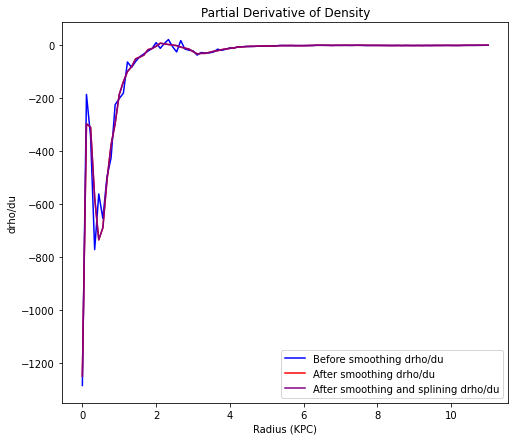

In [6]:
# Plot 
plt.figure(figsize=(8,7))
plt.plot(radii,drho_du_values, label="Before smoothing drho/du", c="blue")
plt.plot(radii,drho_du_smooth, label="After smoothing drho/du", c="red")
plt.plot(radii,spline_drhor(radii), label="After smoothing and splining drho/du", c="purple")
plt.title("Partial Derivative of Density")
plt.xlabel("Radius (KPC)")
plt.ylabel("drho/du")
plt.legend()
plt.show()

## Functions

In [7]:
#from casertano http://articles.adsabs.harvard.edu/pdf/1983MNRAS.203..735C
# Casertano Eq 2
def drho_du(r,u,z):
    return spline_drhor(u) * np.cosh(z / z0)**-2


In [8]:
# Casertano Eq 5
def px(r,u,z):
    x = (r**2 + u**2 + z**2)/(2*r*u)
    return x - ((x**2)-1)**.5


In [9]:
# Complete elliptic integral
def K_E(r,u,z):
    return ellipk(px(r,u,z)) - ellipe(px(r,u,z))

In [10]:
#constants
G = 0.00000431158                   # Gravitational constant (KPC/MSUN*(KM/S)^2)  

#casertano eq 4, simplified
def integrand(r,u,z):
    return (8 * G) * drho_du(r,u,z) * K_E(r,u,z) *(u/(r *px(r,u,z)))**.5


## Integration

In [11]:
# Define minimum and maximum values of radius for integration
intmin = np.min(radii)
intmax = np.max(radii)
#intmax=np.inf ????

In [26]:
# Reverse order of variables to setup for integration
integrand2 = lambda z,u,r: integrand(r,u,z)

# Integrate double integral

from scipy import integrate

radialforce= lambda r: integrate.dblquad(integrand2, intmin, intmax, lambda z: intmin, lambda z: intmax)[0]

#radialforce = lambda r: nquad(integrand2, [[intmin,intmax], [intmin,intmax]], args=r)[0]
#radialforce = lambda 
radialforce = np.vectorize(radialforce)
FF=radialforce(3)
print(FF)

TypeError: <lambda>() missing 1 required positional argument: 'r'

## Velocity

In [ ]:
#casertano eq 6:
velocs = (-radii*radialforce(radii))**.5
scale = 5e2
velocs=velocs*scale
#velocs=[x for x in velocs if x <= 43]
#radii = np.linspace(0.001,11,len(velocs))                # Sampling radii
#velocs_smooth = savgol_filter(velocs, 11, 4)

## Comparison

In [ ]:
# Gas
tracedgas = np.loadtxt("../NGC_5005/traced_data/ngc5005_gas.txt")
tracedgas_r, tracedgas_v = tracedgas.T
tracedgas_r = tracedgas_r[1:]
tracedgas_v = tracedgas_v[1:]

# Disk
traceddisk = np.loadtxt("../NGC_5005/traced_data/ngc5005_disk.txt")
traceddisk_r, traceddisk_v = traceddisk.T
traceddisk_r = traceddisk_r[1:]
traceddisk_v = traceddisk_v[1:]

## Plot

In [ ]:
newscale=3
plt.figure(figsize=(8,6))             
plt.scatter(radii, newscale*np.asarray(velocs), linestyle='solid', label='Scaled calculated gas velocity by {}'.format(scale))
#plt.plot(radii, 1e3*velocs_smooth, linestyle='solid', label='Smoothed Gas Velocity')
plt.scatter(tracedgas_r, tracedgas_v, label='Expected Gas Velocity', c='red')
plt.axis('tight');
plt.title('NGC 5005')
plt.xlabel('Radius (KPC)', fontsize=10)
plt.ylabel('Velocity (KM/S)', fontsize=10)
#plt.xlim(0,12)
plt.legend(fontsize=10)
plt.show()